In [1]:
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from networkx.algorithms.approximation import maximum_independent_set

from utils.graph_funcs import graph_from_file, is_indset
from utils.helper_funcs import hamming_weight

matplotlib.rc('xtick', labelsize=13)     
matplotlib.rc('ytick', labelsize=13)
plt.rcParams["font.family"] = "Times New Roman"

In [155]:
onlinemis_N20 = 1.082142857142857
onlinemis_N60 = 1.1055965817596252
onlinemis_N100 = 1.0992965435797255

# Data Loading

In [2]:
def get_pickles(N, graph_type, graph_val, npm, ns, verbose=0, quantum=True):
    if quantum:
        print(f'LOADING Quantum N{N}_{graph_type}{graph_val}_NS{ns}_NPM{npm}')
    else:
        print(f'LOADING Classical N{N}_{graph_type}{graph_val}_NS{ns}')
        
    retval = []
    
    if quantum:
        base_path = f'benchmark_results/QLS_N{N}_{graph_type}{graph_val}_graphs/'
        graph_dirs = glob.glob(base_path + f'NS{ns}_NPM{npm}/*')
    else:
        base_path = f'benchmark_results/CLS_N{N}_{graph_type}{graph_val}_graphs/'
        graph_dirs = glob.glob(base_path + f'NS{ns}/*')
    if verbose:
        print('base path:', base_path)
    
    
    graph_dirs = sorted(graph_dirs, key=lambda fn: int(fn.split('/')[-1].strip('G')))
    
    for gd in graph_dirs:
        if verbose:
            print(gd)
        all_reps = glob.glob(gd+'/*')
        
        graphfn = f'benchmark_graphs/N{N}_{graph_type}{graph_val}_graphs/{gd.split("/")[-1]}.txt'

        G = graph_from_file(graphfn)
        graph_name = 'N{}_{}{}_{}'.format(N, graph_type, graph_val, gd.split('/')[-1])

        bh_mis = len(maximum_independent_set(G))
        
        temp_pickles = []
        for pklfile in all_reps:
            with open(pklfile, 'rb') as pf:
                res = pickle.load(pf)
                temp_pickles.append((pklfile.split('_')[-1].strip('.pickle'), res['out']))

        # after collecting reps for this graph, store the results
        retval.append((G, bh_mis, temp_pickles, graph_name))
            
    return retval

# Plotting individual graph results

In [15]:
def plot_qls_approxs(data, savedir=None, show=True, verbose=0):
    
    G, bh_mis, outs, graph_name = data
    if verbose:
        print(graph_name)
        print('\tBoppana-Halldorsson MIS =', bh_mis)
    
    fig, ax = plt.subplots(dpi=150)

    outs = sorted(outs, key=lambda tup: int(tup[0].strip('rep')))
    for r, (rep, out) in enumerate(outs):
        qls_mis, history = out
        
        if verbose > 0:
            print('\t{}: QLS MIS = {}, {} iterations'.format(rep, hamming_weight(qls_mis), len(history)))
        
        x_vals, y_vals = [], []
        for i, iteration in enumerate(history):
            x_vals.append(i+1)
            approximation_ratio = abs(hamming_weight(iteration[-1]) / bh_mis)
            y_vals.append(approximation_ratio)

        ax.plot(x_vals, y_vals, alpha=0.3, label=rep)
        ax.scatter(x_vals, y_vals, alpha=0.3, s=20)
        
    ax.axhline(y=1, ls='--', c='k', alpha=0.2)

    ax.set_title('QLS on {}'.format(graph_name))
    ax.set_ylabel('Boppana-Halldorsson Approximation Ratio')
    ax.set_xlabel('Iteration')
    ax.legend()
    
    if not savedir is None:
        if savedir[-1] != '/':
            savedir += '/'
        plt.savefig(savedir + graph_name + '.png')
        
    if show:
        plt.show()
    plt.close()
    
    #if len(iterations_to_opt) > 0:
    #    retval = np.mean(iterations_to_opt)
    #else:
    #    retval = None
    #return retval

In [39]:
data = get_pickles(20, 'd', 3, 5, verbose=1)

base path: benchmark_results/QLS_N20_d3_graphs/
benchmark_results/QLS_N20_d3_graphs/NPM_5/G1
benchmark_results/QLS_N20_d3_graphs/NPM_5/G2
benchmark_results/QLS_N20_d3_graphs/NPM_5/G3
benchmark_results/QLS_N20_d3_graphs/NPM_5/G4
benchmark_results/QLS_N20_d3_graphs/NPM_5/G5
benchmark_results/QLS_N20_d3_graphs/NPM_5/G6
benchmark_results/QLS_N20_d3_graphs/NPM_5/G7
benchmark_results/QLS_N20_d3_graphs/NPM_5/G8
benchmark_results/QLS_N20_d3_graphs/NPM_5/G9
benchmark_results/QLS_N20_d3_graphs/NPM_5/G10
benchmark_results/QLS_N20_d3_graphs/NPM_5/G11
benchmark_results/QLS_N20_d3_graphs/NPM_5/G12
benchmark_results/QLS_N20_d3_graphs/NPM_5/G13
benchmark_results/QLS_N20_d3_graphs/NPM_5/G14
benchmark_results/QLS_N20_d3_graphs/NPM_5/G15
benchmark_results/QLS_N20_d3_graphs/NPM_5/G16
benchmark_results/QLS_N20_d3_graphs/NPM_5/G17
benchmark_results/QLS_N20_d3_graphs/NPM_5/G18
benchmark_results/QLS_N20_d3_graphs/NPM_5/G19
benchmark_results/QLS_N20_d3_graphs/NPM_5/G20


20
N20_d3_G1
	Boppana-Halldorsson MIS = 8
	rep1: QLS MIS = 7, 4 iterations
	rep2: QLS MIS = 8, 4 iterations
	rep3: QLS MIS = 8, 4 iterations
	rep4: QLS MIS = 8, 4 iterations
	rep5: QLS MIS = 7, 4 iterations
	rep6: QLS MIS = 7, 3 iterations
	rep7: QLS MIS = 7, 3 iterations
	rep8: QLS MIS = 7, 4 iterations
	rep9: QLS MIS = 8, 4 iterations
	rep10: QLS MIS = 8, 4 iterations


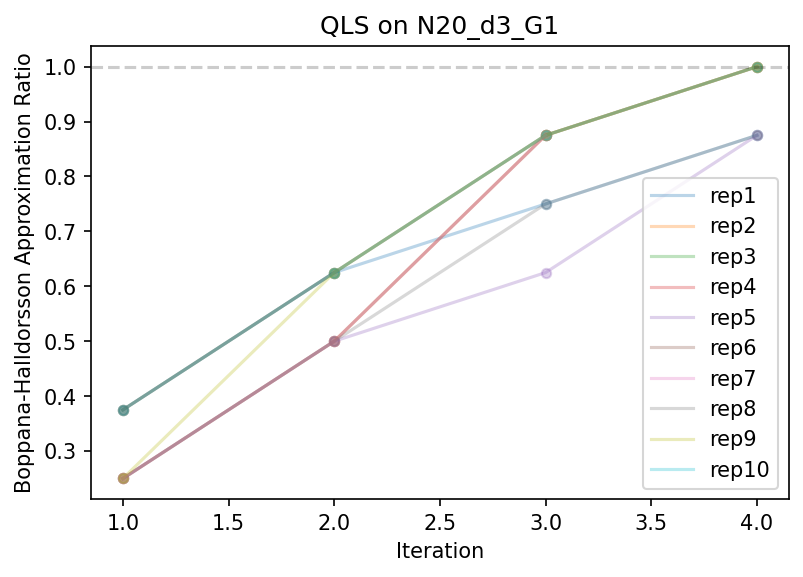

In [40]:
print(len(data))
plot_qls_approxs(data[0], verbose=1)

In [25]:
for N in [20, 60, 100]:
    data = get_pickles(N, 'd', 3, 5)
    savedir = 'figures/N{}_d3_QLS_iterations/'.format(N)
    for dat in data:
        plot_qls_approxs(dat, savedir=savedir, show=False, verbose=0)

base path: benchmark_results/QLS_N20_d3_graphs/
benchmark_results/QLS_N20_d3_graphs/NPM_5/G1
benchmark_results/QLS_N20_d3_graphs/NPM_5/G2
benchmark_results/QLS_N20_d3_graphs/NPM_5/G3
benchmark_results/QLS_N20_d3_graphs/NPM_5/G4
benchmark_results/QLS_N20_d3_graphs/NPM_5/G5
benchmark_results/QLS_N20_d3_graphs/NPM_5/G6
benchmark_results/QLS_N20_d3_graphs/NPM_5/G7
benchmark_results/QLS_N20_d3_graphs/NPM_5/G8
benchmark_results/QLS_N20_d3_graphs/NPM_5/G9
benchmark_results/QLS_N20_d3_graphs/NPM_5/G10
benchmark_results/QLS_N20_d3_graphs/NPM_5/G11
benchmark_results/QLS_N20_d3_graphs/NPM_5/G12
benchmark_results/QLS_N20_d3_graphs/NPM_5/G13
benchmark_results/QLS_N20_d3_graphs/NPM_5/G14
benchmark_results/QLS_N20_d3_graphs/NPM_5/G15
benchmark_results/QLS_N20_d3_graphs/NPM_5/G16
benchmark_results/QLS_N20_d3_graphs/NPM_5/G17
benchmark_results/QLS_N20_d3_graphs/NPM_5/G18
benchmark_results/QLS_N20_d3_graphs/NPM_5/G19
benchmark_results/QLS_N20_d3_graphs/NPM_5/G20
N20_d3_G1
	Boppana-Halldorsson MIS = 8
N2

# Plotting average performance over all graphs and all reps

In [3]:
def avg_all_graphs_all_reps(all_data, N, graph_type, graph_val, verbose=0, extra_data=None, savefn=None):
    ns_fmt_dict = {2:'-o', 3:'--o', 4:':o'}
    plt_tab_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
    npm_color_dict = {key: color for key, color in zip(list(set([d[1] for d in all_data])), plt_tab_colors)}
    fig, ax = plt.subplots(dpi=150, figsize=[9,6])
    
    # For each set of data with NPM = k
    for (ns, npm, data) in all_data:
        quantum = True
        if npm == -1:
            quantum = False
        if verbose:
            if quantum:
                print(f'NS{ns} NPM{npm}, {len(data)} graphs')
            else:
                print(f'NS{ns}, {len(data)} graphs')
        all_graph_y_vals = []
        # For each graph within that data set
        for (G, bh_mis, outs, graph_name) in data:
            if verbose:
                print(f'{graph_name}, {len(outs)}')
            all_rep_y_vals = []
            # For each repetition on each graph
            for (rep, out) in outs:
                qls_mis, history = out
                temp_y_vals = []
                # For each iteration within every repetition
                for iteration in history:
                    approximation_ratio = abs(hamming_weight(iteration[-1]) / bh_mis)
                    temp_y_vals.append(approximation_ratio)
                all_rep_y_vals.append((hamming_weight(qls_mis) / bh_mis, temp_y_vals))
            
            # Once all the reps have been collected, take the best repetition
            all_graph_y_vals.append(sorted(all_rep_y_vals, key=lambda tup: tup[0])[-1][1])
        
        # Once all the graphs have been collected, average over them
        max_iters = max([len(graph) for graph in all_graph_y_vals])
        #if npm == 4 and N == 60:
        #    max_iters -= 1
        #if npm == 3 and N == 100:
        #    max_iters -= 1
        avg_y_vals = []
        std_y_vals = []
        for i in range(max_iters):
            cur_iter_vals = []
            for graph in all_graph_y_vals:
                if i < len(graph):
                    cur_iter_vals.append(graph[i])
            avg_y_vals.append(np.mean(cur_iter_vals))
            std_y_vals.append(np.std(cur_iter_vals))
            
        # After all the data has been averaged, plot the results
        if quantum:
            label = f'QLS $N_s = {ns}$, $npm = {npm}$'
            fmt = ns_fmt_dict[ns]
            color = npm_color_dict[npm]
        else:
            label = f'CLS $N_s = {ns}$'
            fmt = ns_fmt_dict[ns]
            color = 'grey'
            
        xvals = np.arange(1, len(avg_y_vals)+1)
        ax.errorbar(xvals, avg_y_vals, label=label, fmt=fmt, c=color, ms=4)

        y1 = [m+s for m, s in zip(avg_y_vals, std_y_vals)]
        y2 = [m-s for m, s in zip(avg_y_vals, std_y_vals)]
        ax.fill_between(xvals, y1, y2, alpha=0.1, color=color)
    
    if extra_data is not None:
        for (label, val) in extra_data:
            ax.axhline(y=val, ls='--', alpha=0.4, label=label)
        
    ax.axhline(y=1, ls='--', c='k', alpha=0.2)
    ax.legend(fontsize=8, ncol=2)
    ax.set_ylabel('Boppana-Halldorsson Approximation Ratio', fontsize=13)
    ax.set_xlabel('Iteration', fontsize=13)
    ax.set_title(f'Average QLS performance ({N} node, {graph_type}{graph_val} graphs)')
    
    if savefn is not None:
        plt.savefig(savefn)
    
    plt.show()
    plt.close()

## N = 20

### 3-regular graphs

In [245]:
all_data = []
all_classical_data = []
N = 20
graph_type = 'd'
graph_val = 3
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, graph_val, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, graph_val, -1, ns, quantum=False)))

LOADING Quantum N20_d3_NS2_NPM2
LOADING Quantum N20_d3_NS2_NPM4
LOADING Quantum N20_d3_NS2_NPM6
LOADING Quantum N20_d3_NS2_NPM8
LOADING Quantum N20_d3_NS2_NPM10
LOADING Classical N20_d3_NS2
LOADING Quantum N20_d3_NS3_NPM2
LOADING Quantum N20_d3_NS3_NPM4
LOADING Quantum N20_d3_NS3_NPM6
LOADING Quantum N20_d3_NS3_NPM8
LOADING Quantum N20_d3_NS3_NPM10
LOADING Classical N20_d3_NS3
LOADING Quantum N20_d3_NS4_NPM2
LOADING Quantum N20_d3_NS4_NPM4
LOADING Quantum N20_d3_NS4_NPM6
LOADING Quantum N20_d3_NS4_NPM8
LOADING Quantum N20_d3_NS4_NPM10
LOADING Classical N20_d3_NS4


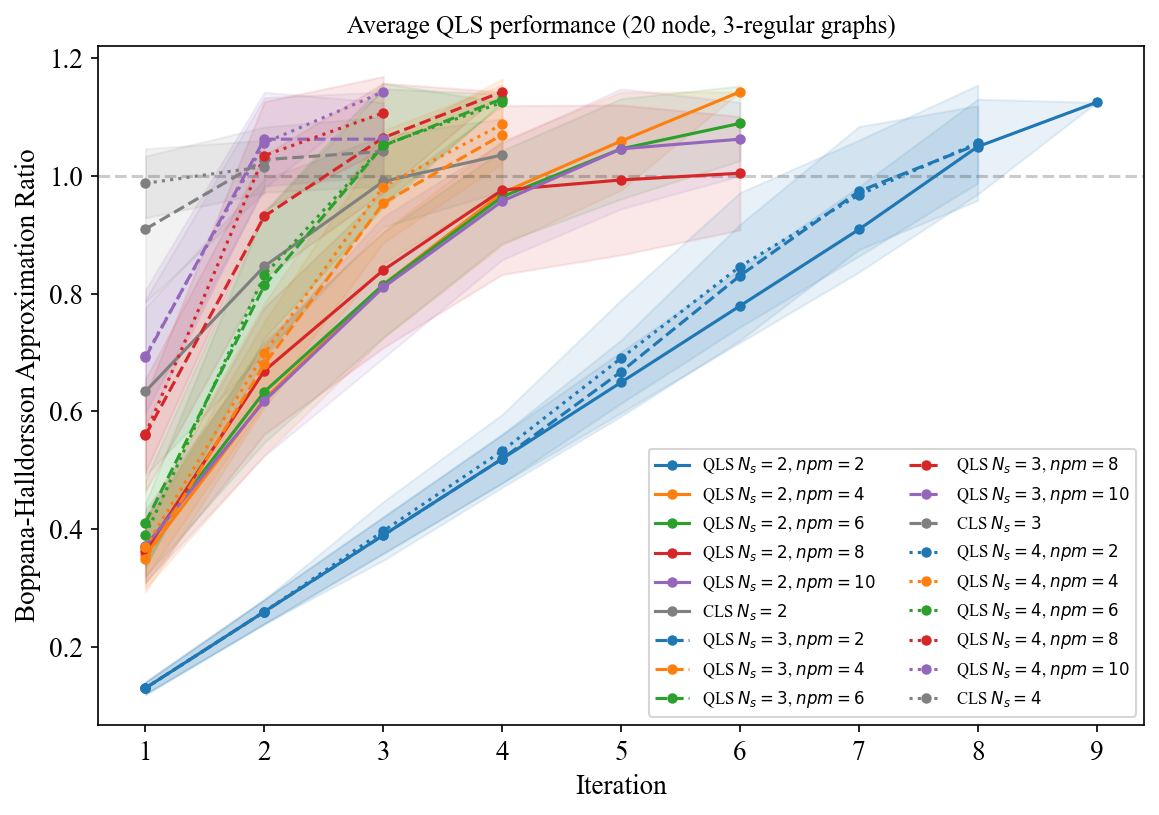

In [254]:
#extra_data = [('OnlineMIS', onlinemis_N20)]
extra_data = None
savefn = 'figures/qls_N20.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, graph_val, extra_data=extra_data, savefn=None, verbose=0)

### Planted-partition graphs

In [9]:
all_data = []
all_classical_data = []
N = 20
graph_type = 'com'
graph_val = '1_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, graph_val, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, graph_val, -1, ns, quantum=False)))

LOADING Quantum N20_com1_pin10_pout2_NS2_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM10
LOADING Classical N20_com1_pin10_pout2_NS2
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM10
LOADING Classical N20_com1_pin10_pout2_NS3
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM10
LOADING Classical N20_com1_pin10_pout2_NS4


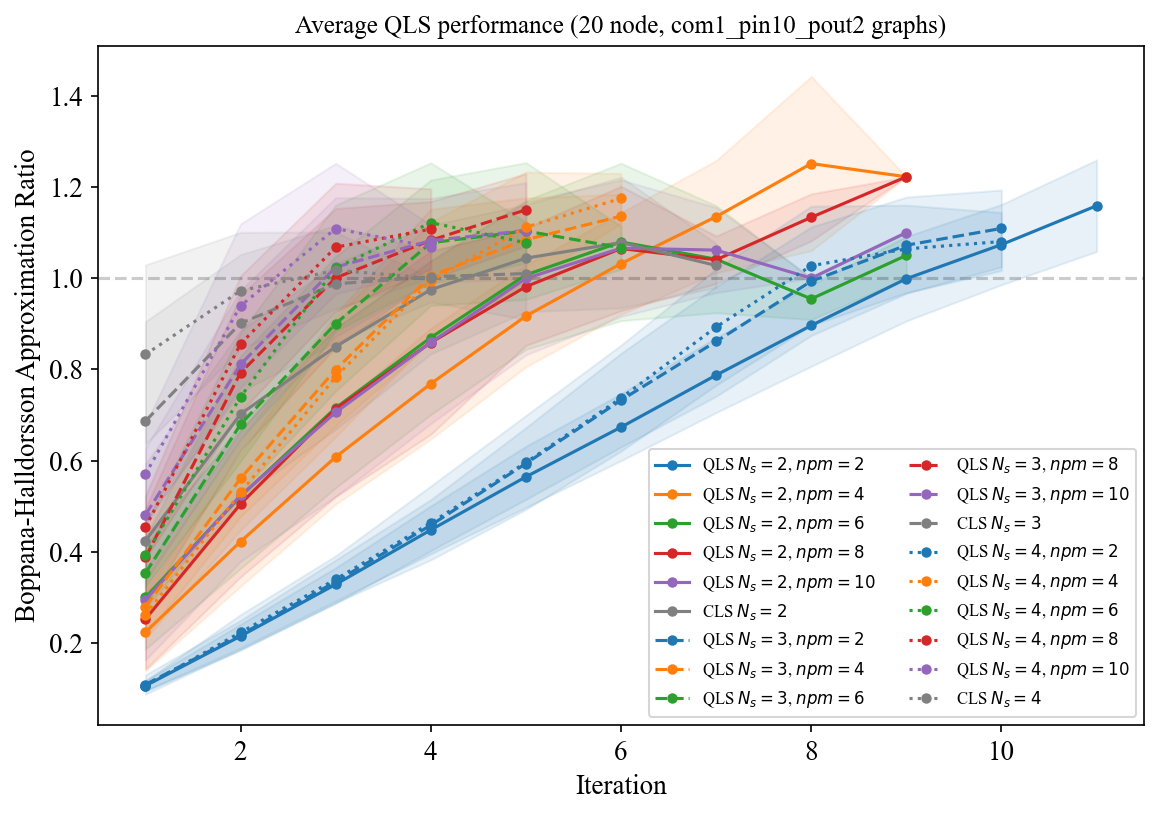

In [12]:
#extra_data = [('OnlineMIS', onlinemis_N20)]
extra_data = None
savefn = 'figures/qls_N20.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, graph_val, extra_data=extra_data, savefn=None, verbose=0)

## N = 60

### 3-regular graphs

In [255]:
all_data = []
N = 60
graph_type = 'd'
graph_val = 3
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, graph_val, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, graph_val, -1, ns, quantum=False)))

LOADING Quantum N60_d3_NS2_NPM2
LOADING Quantum N60_d3_NS2_NPM4
LOADING Quantum N60_d3_NS2_NPM6
LOADING Quantum N60_d3_NS2_NPM8
LOADING Quantum N60_d3_NS2_NPM10
LOADING Classical N60_d3_NS2
LOADING Quantum N60_d3_NS3_NPM2
LOADING Quantum N60_d3_NS3_NPM4
LOADING Quantum N60_d3_NS3_NPM6
LOADING Quantum N60_d3_NS3_NPM8
LOADING Quantum N60_d3_NS3_NPM10
LOADING Classical N60_d3_NS3
LOADING Quantum N60_d3_NS4_NPM2
LOADING Quantum N60_d3_NS4_NPM4
LOADING Quantum N60_d3_NS4_NPM6
LOADING Quantum N60_d3_NS4_NPM8
LOADING Quantum N60_d3_NS4_NPM10
LOADING Classical N60_d3_NS4


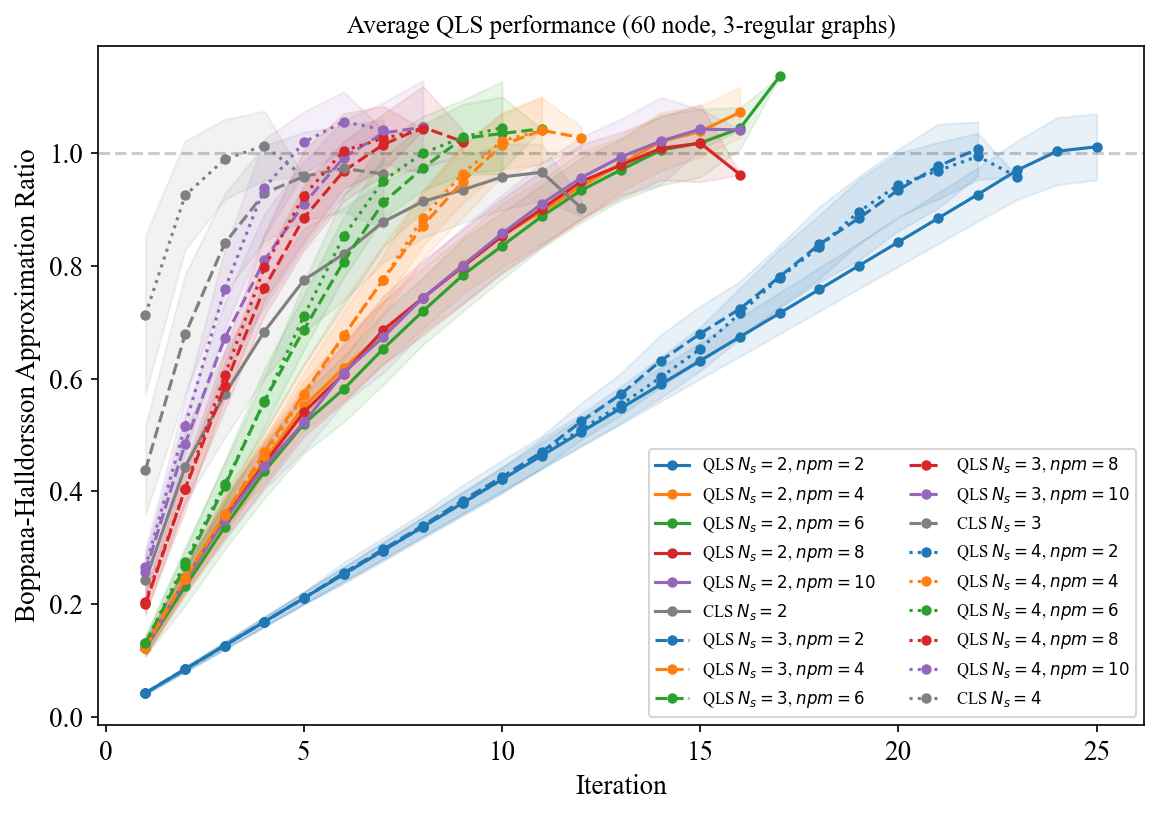

In [256]:
#extra_data = [('OnlineMIS', onlinemis_N20)]
extra_data = None
savefn = 'figures/qls_N60.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, graph_val, extra_data=extra_data, savefn=None, verbose=0)

### Planted-partition graphs

In [19]:
all_data = []
all_classical_data = []
N = 60
graph_type = 'com'
graph_val = '3_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8]:
        all_data.append((ns, npm, get_pickles(N, graph_type, graph_val, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, graph_val, -1, ns, quantum=False)))

LOADING Quantum N60_com3_pin10_pout2_NS2_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM8
LOADING Classical N60_com3_pin10_pout2_NS2
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM8
LOADING Classical N60_com3_pin10_pout2_NS3
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM8
LOADING Classical N60_com3_pin10_pout2_NS4


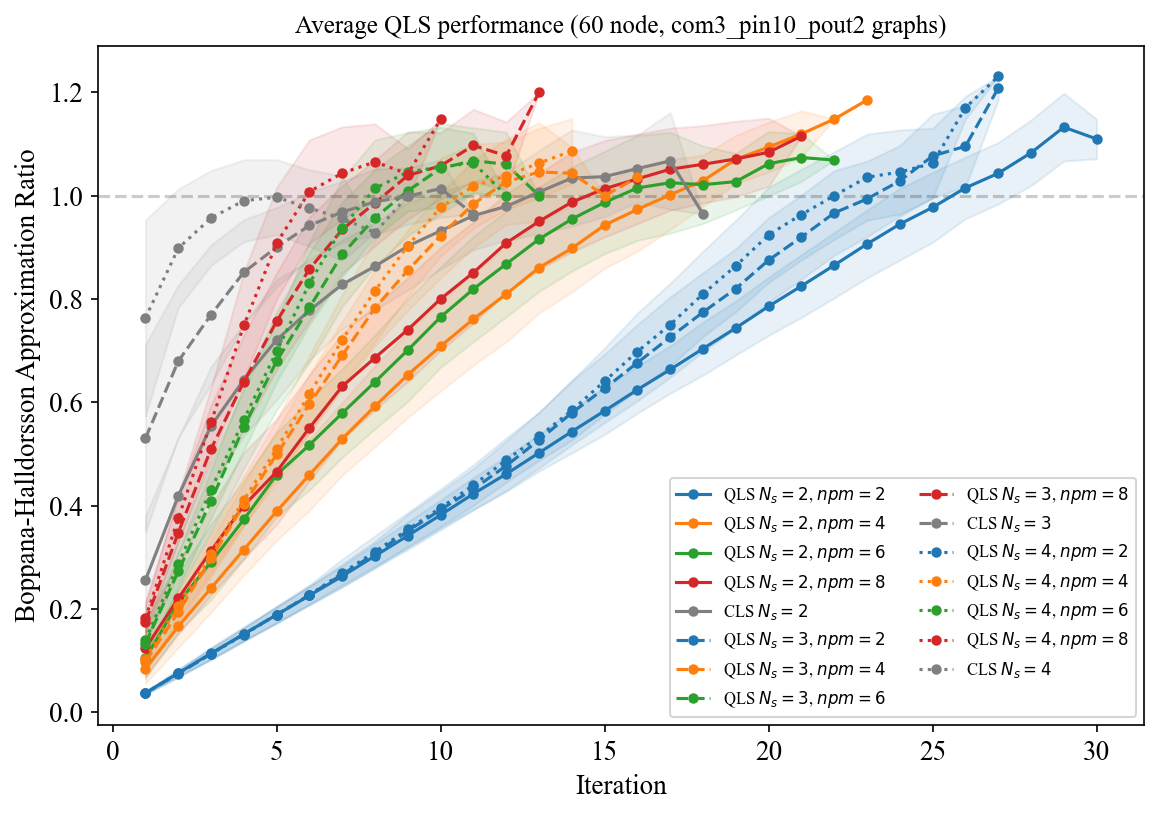

In [21]:
#extra_data = [('OnlineMIS', onlinemis_N20)]
extra_data = None
savefn = 'figures/qls_N20.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, graph_val, extra_data=extra_data, savefn=None, verbose=0)

## N = 100

### 3-regular graphs

In [257]:
all_data = []
N = 100
graph_type = 'd'
graph_val = 3
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, graph_val, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, graph_val, -1, ns, quantum=False)))

LOADING Quantum N100_d3_NS2_NPM2
LOADING Quantum N100_d3_NS2_NPM4
LOADING Quantum N100_d3_NS2_NPM6
LOADING Quantum N100_d3_NS2_NPM8
LOADING Quantum N100_d3_NS2_NPM10
LOADING Classical N100_d3_NS2
LOADING Quantum N100_d3_NS3_NPM2
LOADING Quantum N100_d3_NS3_NPM4
LOADING Quantum N100_d3_NS3_NPM6
LOADING Quantum N100_d3_NS3_NPM8
LOADING Quantum N100_d3_NS3_NPM10
LOADING Classical N100_d3_NS3
LOADING Quantum N100_d3_NS4_NPM2
LOADING Quantum N100_d3_NS4_NPM4
LOADING Quantum N100_d3_NS4_NPM6
LOADING Quantum N100_d3_NS4_NPM8
LOADING Quantum N100_d3_NS4_NPM10
LOADING Classical N100_d3_NS4


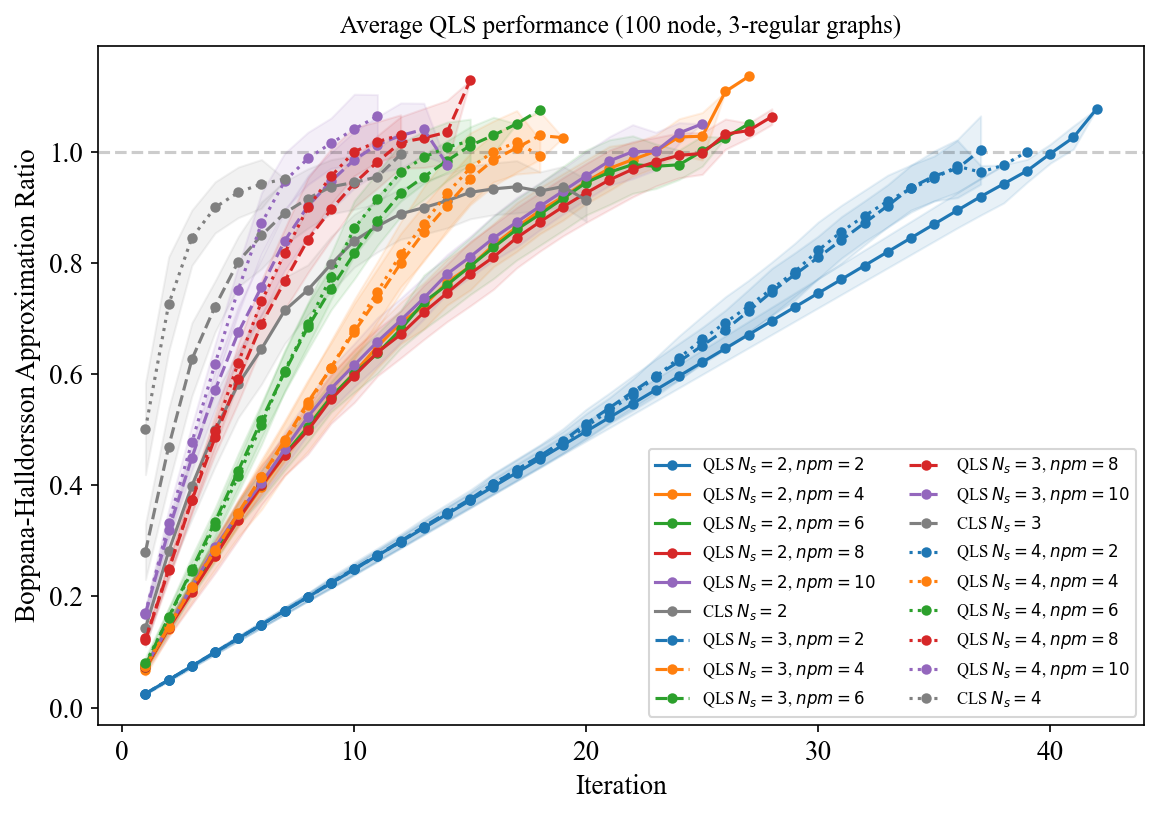

In [258]:
#extra_data = [('OnlineMIS', onlinemis_N20)]
extra_data = None
savefn = 'figures/qls_N100.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, graph_val, extra_data=extra_data, savefn=None, verbose=0)

### Planted-partition graphs

In [4]:
all_data = []
all_classical_data = []
N = 100
graph_type = 'com'
graph_val = '5_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 3, 4, 5, 6]:
        all_data.append((ns, npm, get_pickles(N, graph_type, graph_val, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, graph_val, -1, ns, quantum=False)))

LOADING Quantum N100_com5_pin10_pout2_NS2_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM3
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM5
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM6
LOADING Classical N100_com5_pin10_pout2_NS2
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM3
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM5
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM6
LOADING Classical N100_com5_pin10_pout2_NS3
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM3
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM5
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM6
LOADING Classical N100_com5_pin10_pout2_NS4


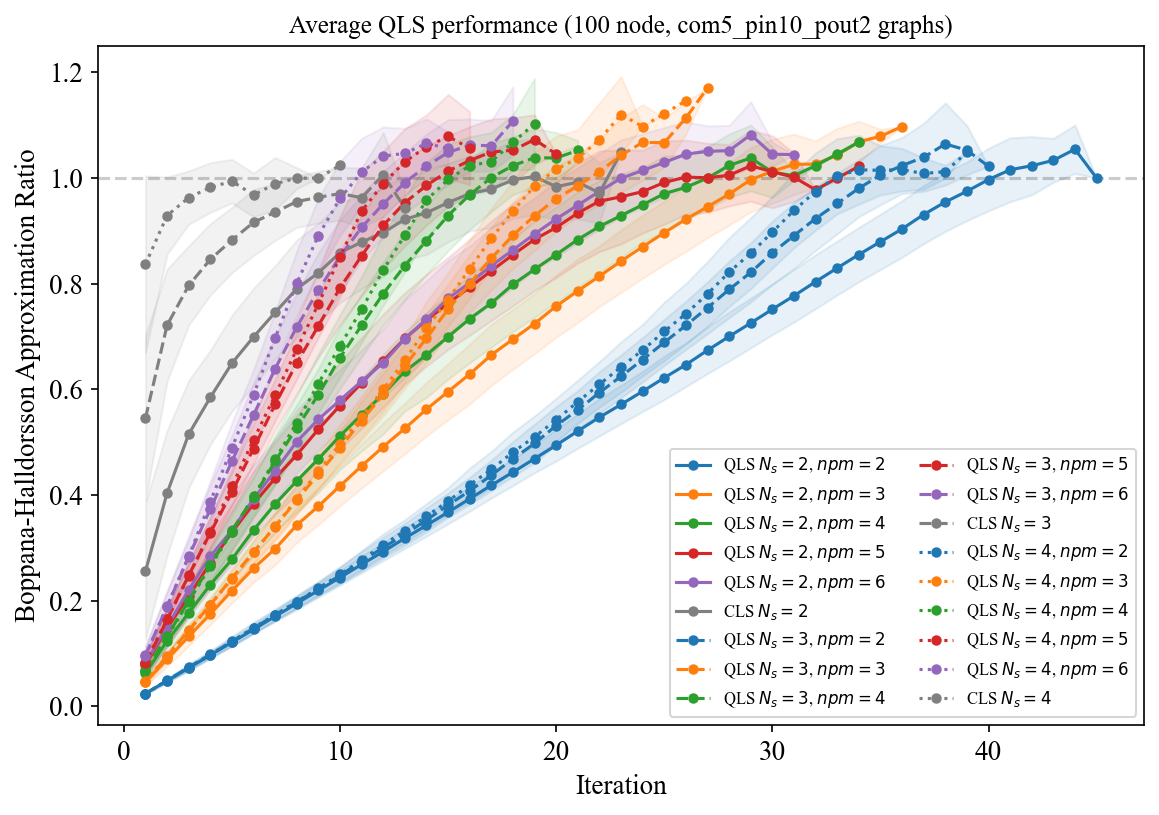

In [5]:
#extra_data = [('OnlineMIS', onlinemis_N20)]
extra_data = None
savefn = 'figures/qls_N20.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, graph_val, extra_data=extra_data, savefn=None, verbose=0)

## Plot everything in a single figure

In [12]:
def one_plot_all_data(all_data, N, graph_type, graph_val, verbose=0, extra_data=None, savefn=None):
    fig, ax = plt.subplots(dpi=150, ncols=len(all_data), sharey=True, figsize=[12,3])
    
    for cur_ax, n_data, n in zip(ax, all_data, N):
        # For each set of data with NPM = k
        for (npm, data) in n_data:
            if verbose:
                print('NPM', npm, ',', len(data), 'graphs')
            all_graph_y_vals = []
            # For each graph within that data set
            for (G, bh_mis, outs, graph_name) in data:
                if verbose:
                    print(graph_name, ',', len(outs), 'reps')
                all_rep_y_vals = []
                # For each repetition on each graph
                for (rep, out) in outs:
                    qls_mis, history = out
                    temp_y_vals = []
                    # For each iteration within every repetition
                    for iteration in history:
                        approximation_ratio = abs(hamming_weight(iteration[-1]) / bh_mis)
                        temp_y_vals.append(approximation_ratio)
                    all_rep_y_vals.append((hamming_weight(qls_mis) / bh_mis, temp_y_vals))

                # Once all the reps have been collected, take the best repetition
                all_graph_y_vals.append(sorted(all_rep_y_vals, key=lambda tup: tup[0])[-1][1])

            # Once all the graphs have been collected, average over them
            max_iters = max([len(graph) for graph in all_graph_y_vals])
            if npm == 4 and n == 60:
                max_iters -= 1
            if npm == 3 and n == 100:
                max_iters -= 1
            avg_y_vals = []
            std_y_vals = []
            for i in range(max_iters):
                cur_iter_vals = []
                for graph in all_graph_y_vals:
                    if i < len(graph):
                        cur_iter_vals.append(graph[i])
                avg_y_vals.append(np.mean(cur_iter_vals))
                std_y_vals.append(np.std(cur_iter_vals))

            # After all the data has been averaged, plot the results
            label = r'$k = {}$'.format(npm)
            xvals = np.arange(1, len(avg_y_vals)+1)
            cur_ax.errorbar(xvals, avg_y_vals, label=label, fmt='-o', ms=4)

            y1 = [m+s for m, s in zip(avg_y_vals, std_y_vals)]
            y2 = [m-s for m, s in zip(avg_y_vals, std_y_vals)]
            cur_ax.fill_between(xvals, y1, y2, alpha=0.2)

        if extra_data is not None:
            for (label, val) in extra_data:
                cur_ax.axhline(y=val, ls='--', alpha=0.4, label=label)
        
        cur_ax.axhline(y=1, ls='--', c='k', alpha=0.2)
        cur_ax.set_xlabel('Iteration', fontsize=13)
        cur_ax.set_title('{} node, 3-regular graphs'.format(n))
    
    ax[0].legend()
    ax[0].set_ylabel('Boppana-Halldorsson\nApproximation Ratio', fontsize=13)
    plt.tight_layout()
    
    if savefn is not None:
        plt.savefig(savefn)
    
    plt.show()
    plt.close()

In [9]:
all_data = []
graph_type = 'd'
graph_val = 3
Nvals = [20, 60, 100]
for N in Nvals:
    n_data = []
    for npm in [2, 3, 4, 10]:
        n_data.append((npm, get_pickles(N, graph_type, graph_val, npm)))
    all_data.append(n_data)

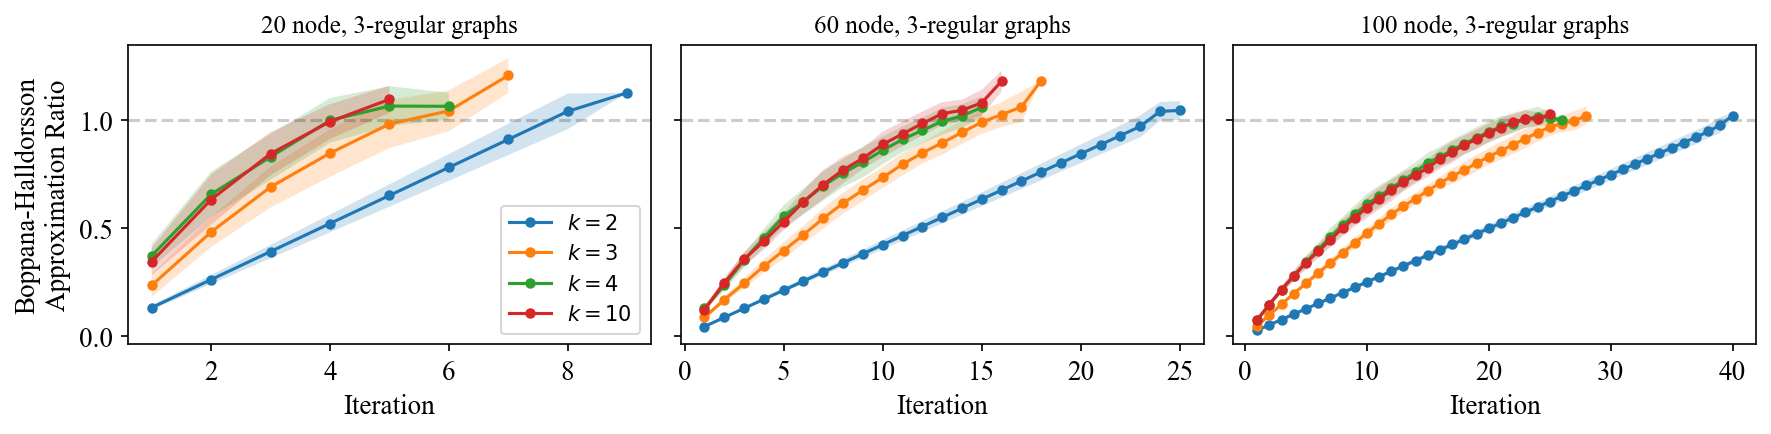

In [13]:
#extra_data = [('OnlineMIS', onlinemis_N100)]
extra_data = None
one_plot_all_data(all_data, Nvals, graph_type, graph_val, verbose=0, extra_data=extra_data, savefn='figures/qls_performance.pdf')

# Plotting average approximation ratio as a function of NPM

In [137]:
def mis_performance(all_data, graph_type, graph_val, verbose=0, extra_data=None, savefn=None, classical_data=None):
    fig, ax = plt.subplots(dpi=150, figsize=[9,6])
    
    for (N, cur_data) in all_data:
        avg_y_vals = []
        std_y_vals = []
        x_vals = []
        # For each set of data with NS = n, NPM = k
        for (ns, npm, data) in cur_data:
            if verbose:
                print(f'NS = {ns}, NPM = {npm}, {len(data)} graphs')
            all_graph_y_vals = []
            # For each graph within that data set
            for (G, bh_mis, outs, graph_name) in data:
                if verbose:
                    print(f'\t{graph_name}, {len(outs)} reps')
                all_rep_y_vals = []
                # For each repetition on each graph
                for (rep, out) in outs:
                    qls_mis, history = out
                    all_rep_y_vals.append(hamming_weight(qls_mis) / bh_mis)

                # Once all the reps have been collected, take the best rep
                all_graph_y_vals.append(np.max(all_rep_y_vals))

            # Once all the graphs have been collected, average over them
            avg_y_vals.append(np.mean(all_graph_y_vals))
            std_y_vals.append(np.std(all_graph_y_vals))
            x_vals.append(npm)

        # After all the data has been averaged, plot the results
        ax.errorbar(x_vals, avg_y_vals, fmt='-o', ms=4, label=f'QLS ($N = {N}$, $N_s = {ns}$)')

        y1 = [m+s for m, s in zip(avg_y_vals, std_y_vals)]
        y2 = [m-s for m, s in zip(avg_y_vals, std_y_vals)]
        ax.fill_between(x_vals, y1, y2, alpha=0.2)
        
    if classical_data:
        for N, ns, data in classical_data:
            if verbose:
                print(f'Classical local search: N = {N}, NS = {ns}, {len(data)} graphs')
            all_graph_y_vals = []
            for G, bh_mis, outs, graph_name in data:
                if verbose:
                    print(f'\t{graph_name}, {len(outs)} reps')
                all_rep_y_vals = []
                for rep, out in outs:
                    cls_mis, history = out
                    all_rep_y_vals.append(hamming_weight(cls_mis) / bh_mis)
                
                # Retain the best out of len(out) reps
                all_graph_y_vals.append(np.max(all_rep_y_vals))
            
            avg_y_val = np.mean(all_graph_y_vals)
            std_y_vals.append(np.std(all_graph_y_vals))
            
            ax.axhline(y=avg_y_val, xmin=0.04, xmax=0.96, ls='-.', label=f'CLS ($N = {N}$, $N_s = {ns}$)')
        
    if extra_data:
        colors = ['tab:blue', 'tab:orange', 'tab:green']
        for i, (label, val) in enumerate(extra_data):
            ax.axhline(y=val, xmin=0.04, xmax=0.96, ls='--', alpha=0.4, label=label, c=colors[i])
    
    ax.axhline(y=1, xmin=0.04, xmax=0.96, ls='--', c='k', alpha=0.2)
    ax.legend(loc=[0.3,0.01], ncol=2, fontsize=8)
    ax.set_ylabel('Boppana-Halldorsson Approximation Ratio', fontsize=12)
    ax.set_xlabel('Number of Partial Mixers', fontsize=12)
    ax.set_title('Avg QLS performance on {}-regular graphs'.format(graph_val))
    
    if savefn is not None:
        plt.savefig(savefn)
    
    plt.show()
    plt.close()

In [117]:
all_data = []
graph_type = 'd'
graph_val = 3
for N in [20, 60, 100]:
    for ns in [2, 3, 4]:
        temp_data = []
        for npm in [2, 4, 6, 8, 10]:
            temp_data.append((ns, npm, get_pickles(N, graph_type, graph_val, npm, ns)))
        all_data.append((N, temp_data))

LOADING Quantum N20_d3_NS2_NPM2
LOADING Quantum N20_d3_NS2_NPM4
LOADING Quantum N20_d3_NS2_NPM6
LOADING Quantum N20_d3_NS2_NPM8
LOADING Quantum N20_d3_NS2_NPM10
LOADING Quantum N20_d3_NS3_NPM2
LOADING Quantum N20_d3_NS3_NPM4
LOADING Quantum N20_d3_NS3_NPM6
LOADING Quantum N20_d3_NS3_NPM8
LOADING Quantum N20_d3_NS3_NPM10
LOADING Quantum N20_d3_NS4_NPM2
LOADING Quantum N20_d3_NS4_NPM4
LOADING Quantum N20_d3_NS4_NPM6
LOADING Quantum N20_d3_NS4_NPM8
LOADING Quantum N20_d3_NS4_NPM10
LOADING Quantum N60_d3_NS2_NPM2
LOADING Quantum N60_d3_NS2_NPM4
LOADING Quantum N60_d3_NS2_NPM6
LOADING Quantum N60_d3_NS2_NPM8
LOADING Quantum N60_d3_NS2_NPM10
LOADING Quantum N60_d3_NS3_NPM2
LOADING Quantum N60_d3_NS3_NPM4
LOADING Quantum N60_d3_NS3_NPM6
LOADING Quantum N60_d3_NS3_NPM8
LOADING Quantum N60_d3_NS3_NPM10
LOADING Quantum N60_d3_NS4_NPM2
LOADING Quantum N60_d3_NS4_NPM4
LOADING Quantum N60_d3_NS4_NPM6
LOADING Quantum N60_d3_NS4_NPM8
LOADING Quantum N60_d3_NS4_NPM10
LOADING Quantum N100_d3_NS2_NPM2
L

In [118]:
all_classical_data = []
for N in [20, 60, 100]:
    for ns in [2, 3, 4]:
        all_classical_data.append((N, ns, get_pickles(N, graph_type, graph_val, -1, ns, quantum=False)))

LOADING Classical N20_d3_NS2
LOADING Classical N20_d3_NS3
LOADING Classical N20_d3_NS4
LOADING Classical N60_d3_NS2
LOADING Classical N60_d3_NS3
LOADING Classical N60_d3_NS4
LOADING Classical N100_d3_NS2
LOADING Classical N100_d3_NS3
LOADING Classical N100_d3_NS4


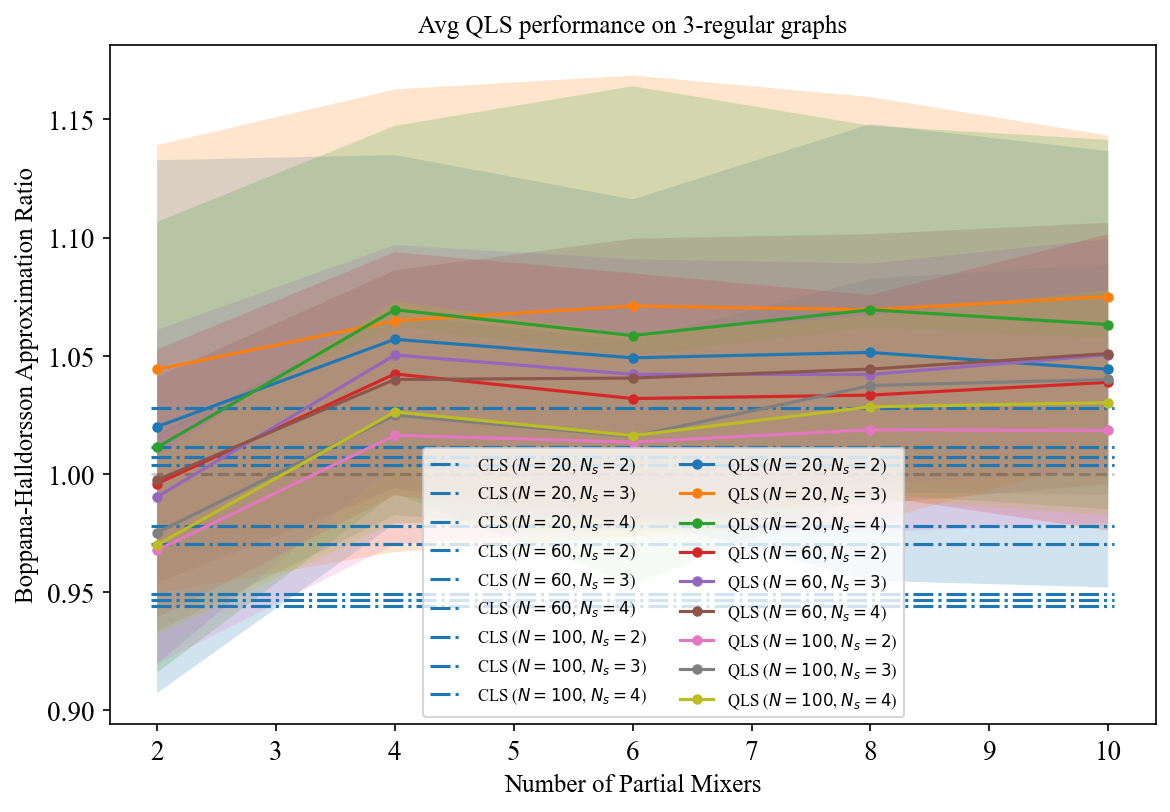

In [138]:
#extra_data = [('OnlineMIS (N=20)', onlinemis_N20), ('OnlineMIS (N=60)', onlinemis_N60), ('OnlineMIS (N=100)', onlinemis_N100)]
extra_data = None
savefn = 'figures/avg_qls_performance.pdf'
mis_performance(all_data, graph_type, graph_val, extra_data=extra_data, savefn=None, classical_data=all_classical_data, verbose=0)

# Plotting average NPM

In [224]:
def plot_npm(all_data, savefn=None):
    fig, ax = plt.subplots(dpi=150)
    
    plot_dict = {}
    all_npm_vals = []
    for (N, ndata) in all_data:
        #print('Num nodes:', N)
        cur_N_dict = {}
        for (npm, pdata) in ndata:
            all_npm_vals.append(npm)
            #print('\tNum partial mixers:', npm)
            temp_avg_npm = []
            for gdata in pdata:
                G, bh_mis, outs, graph_name = gdata
                #print('\t\t', graph_name)
                
                temp_reps = []
                # For each repetition on each graph
                for (rep, out) in outs:
                    qls_mis, history = out
                    # record the final approximation ratio and the number of partial mixers at every iteration
                    temp_reps.append(((hamming_weight(qls_mis) / bh_mis), [len(itr[5]) for itr in history]))

                # Once all the reps have been collected, compute the average number of partial mixers for the best repetition
                best_rep = sorted(temp_reps, key=lambda tup: tup[0])[-1][1]
                temp_avg_npm.append(np.mean(best_rep))
            
            # After all graphs at this NPM have been collected, average them
            cur_N_dict[npm] = np.mean(temp_avg_npm)
        
        # Once all NPM's have been collected, save the results
        plot_dict[N] = cur_N_dict
    
    # Once all N values have been collected, plot!
    all_npm_vals = list(set(all_npm_vals))
    xlabels = list(plot_dict.keys())
    xvals = np.arange(1, len(plot_dict.keys()) + 1)
    width = 0.1
    offset = len(all_npm_vals) // 2 * width
    for i, npm_val in enumerate(all_npm_vals):
        yvals = [plot_dict[N][npm_val] for N in xlabels]
        cur_xvals = [xx - offset + i*width for xx in xvals]
        ax.bar(cur_xvals, yvals, label='NPM Limit = {}'.format(npm_val), width=width)

        
    ax.legend(fontsize=10, loc='lower right', ncol=2)
    ax.set_xticks(xvals)
    ax.set_xticklabels(xlabels)
    ax.set_ylabel('Avg Number of Partial Mixers', fontsize=12)
    ax.set_xlabel('Graph Size, N', fontsize=12)
    ax.set_title('Avg NPM for QLS on 3-regular graphs')
    
    if savefn is not None:
        plt.savefig(savefn)
    
    plt.show()
    plt.close()

In [218]:
all_data = []
graph_type = 'd'
graph_val = 3
for N in [20, 60, 100]:
    temp_data = []
    for npm in [2, 3, 4, 6, 8, 10]:
        temp_data.append((npm, get_pickles(N, graph_type, graph_val, npm)))
    all_data.append((N, temp_data))

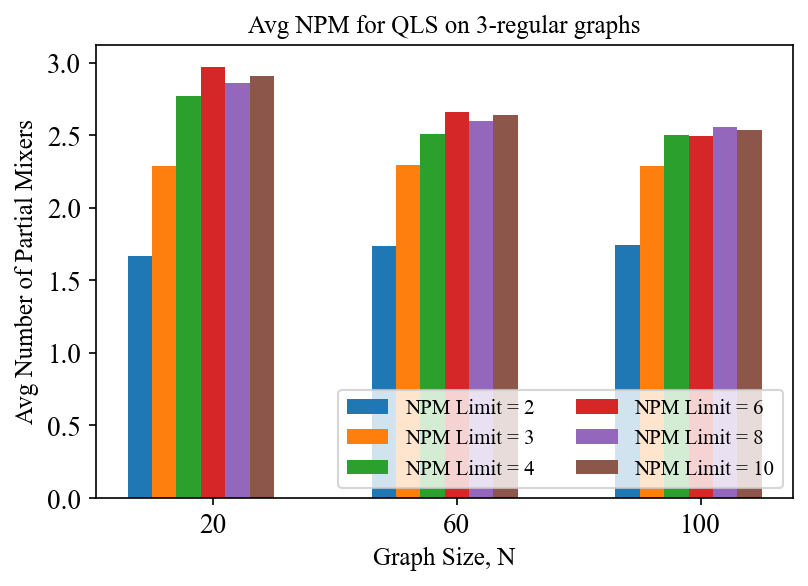

In [225]:
plot_npm(all_data, savefn='figures/avg_qls_npm.pdf')

In [296]:
def circuitsize(all_data, graph_type, graph_val, verbose=0, extra_data=None, savefn=None, classical_data=None):
    npm_color_dict = {2:'tab:blue', 4:'tab:orange', 6:'tab:green', 8:'tab:red', 10:'tab:purple'}
    for N, all_ns_data in all_data:
        fig, ax = plt.subplots(dpi=150, figsize=[9,6])
        for cur_data in all_ns_data:
            # For each set of data with NS = n, NPM = k
            for (ns, npm, data) in cur_data:
                if verbose:
                    print(f'NS = {ns}, NPM = {npm}, {len(data)} graphs')
                temp_all_graph_y_vals = []
                longest_rep = -1
                # For each graph within that data set
                for (G, bh_mis, outs, graph_name) in data:
                    if verbose:
                        print(f'\t{graph_name}, {len(outs)} reps')
                    all_rep_y_vals = []
                    # For each repetition on each graph
                    best_mis = -1
                    for (rep, out) in outs:
                        qls_mis, history = out
                        if hamming_weight(qls_mis) > best_mis:
                            best_history = history

                    # Take the best out of all reps
                    rep_circuit_sizes = []
                    for iteration in best_history:
                        # history.append((init_node, prev_mis_state, induced_G, opt_cost,
                        #                 opt_params, best_hot_nodes, qubits_to_nodes,
                        #                 nodes_to_qubits, cur_mis_state))
                        rep_circuit_sizes.append(len(iteration[6].keys()))

                    # Once all the reps have been collected, take the best rep
                    if len(rep_circuit_sizes) > longest_rep:
                        longest_rep = len(rep_circuit_sizes)
                    temp_all_graph_y_vals.append(rep_circuit_sizes)

                # Once all the graphs have been collected, average over them
                all_graph_y_vals = []
                for qls_execution in temp_all_graph_y_vals:
                    corrected_len_execution = [v for v in qls_execution]
                    if len(qls_execution) < longest_rep:
                        for _ in range(len(qls_execution), longest_rep):
                            corrected_len_execution.append(0)
                    all_graph_y_vals.append(np.array(corrected_len_execution))
                all_graph_y_vals = np.array(all_graph_y_vals)
                avg_y_vals = np.mean(all_graph_y_vals, axis=0)
                std_y_vals = np.std(all_graph_y_vals, axis=0)
                x_vals = np.arange(1,longest_rep+1)

                # After all the data has been averaged, plot the results
                if ns == 2:
                    fmt = '-o'
                elif ns == 3:
                    fmt = '--o'
                elif ns == 4:
                    fmt = ':o'
                ax.errorbar(x_vals, avg_y_vals, fmt=fmt, ms=4, c=npm_color_dict[npm], label=f'QLS ($N_s = {ns}$, $npm = {npm}$)')

                y1 = [m+s for m, s in zip(avg_y_vals, std_y_vals)]
                y2 = [m-s for m, s in zip(avg_y_vals, std_y_vals)]
                ax.fill_between(x_vals, y1, y2, alpha=0.1, color=npm_color_dict[npm])
        
        # Plot classical local search results
        if classical_data:
            for N, ns, cls_data in classical_data[N]:
                temp_all_graph_y_vals = []
                longest_rep = -1
                # For each graph within that data set
                for G, bh_mis, all_reps, graph_name in cls_data:
                    if verbose:
                        print(f'\t{graph_name}, {len(all_reps)} reps')
                    all_rep_y_vals = []
                    # For each repetition on each graph
                    best_mis = -1
                    for rep, out in all_reps:
                        cls_mis, history = out
                        if hamming_weight(cls_mis) > best_mis:
                            best_history = history

                    # Take the best out of all reps
                    rep_neighborhood_sizes = []
                    for iteration in best_history:
                        # history.append((init_node, prev_mis_state, induced_G, cur_mis_state))
                        rep_neighborhood_sizes.append(len(iteration[2].nodes))

                    if len(rep_neighborhood_sizes) > longest_rep:
                        longest_rep = len(rep_neighborhood_sizes)
                    temp_all_graph_y_vals.append(rep_neighborhood_sizes)

                # Once all the graphs have been collected, average over them
                all_graph_y_vals = []
                for cls_execution in temp_all_graph_y_vals:
                    corrected_len_execution = [v for v in cls_execution]
                    if len(cls_execution) < longest_rep:
                        for _ in range(len(cls_execution), longest_rep):
                            corrected_len_execution.append(0)
                    all_graph_y_vals.append(np.array(corrected_len_execution))
                all_graph_y_vals = np.array(all_graph_y_vals)
                avg_y_vals = np.mean(all_graph_y_vals, axis=0)
                std_y_vals = np.std(all_graph_y_vals, axis=0)
                x_vals = np.arange(1,longest_rep+1)
                
                # After all the data has been averaged, plot the results
                if ns == 2:
                    fmt = '-o'
                elif ns == 3:
                    fmt = '--o'
                elif ns == 4:
                    fmt = ':o'
                ax.errorbar(x_vals, avg_y_vals, fmt=fmt, ms=4, c='grey', label=f'CLS ($N_s = {ns}$)')

                y1 = [m+s for m, s in zip(avg_y_vals, std_y_vals)]
                y2 = [m-s for m, s in zip(avg_y_vals, std_y_vals)]
                ax.fill_between(x_vals, y1, y2, alpha=0.1, color='grey')

        # Plot results
        ax.axhline(y=0, xmin=0.04, xmax=0.96, ls='--', c='k', alpha=0.2)
        ax.legend(ncol=3, fontsize=8)
        ax.set_ylabel('Qubits', fontsize=12)
        ax.set_xlabel('QLS Iteration', fontsize=12)
        ax.set_title(f'Avg Circuit size on N={N} {graph_val}-regular graphs')

        if savefn is not None:
            plt.savefig(savefn)

        plt.show()
        plt.close()

In [263]:
all_data = []
graph_type = 'd'
graph_val = 3
for N in [20, 60, 100]:
    ns_data = []
    for ns in [2, 3, 4]:
        temp_data = []
        for npm in [2, 4, 6, 8, 10]:
            temp_data.append((ns, npm, get_pickles(N, graph_type, graph_val, npm, ns)))
        ns_data.append(temp_data)
    all_data.append((N, ns_data))

LOADING Quantum N20_d3_NS2_NPM2
LOADING Quantum N20_d3_NS2_NPM4
LOADING Quantum N20_d3_NS2_NPM6
LOADING Quantum N20_d3_NS2_NPM8
LOADING Quantum N20_d3_NS2_NPM10
LOADING Quantum N20_d3_NS3_NPM2
LOADING Quantum N20_d3_NS3_NPM4
LOADING Quantum N20_d3_NS3_NPM6
LOADING Quantum N20_d3_NS3_NPM8
LOADING Quantum N20_d3_NS3_NPM10
LOADING Quantum N20_d3_NS4_NPM2
LOADING Quantum N20_d3_NS4_NPM4
LOADING Quantum N20_d3_NS4_NPM6
LOADING Quantum N20_d3_NS4_NPM8
LOADING Quantum N20_d3_NS4_NPM10
LOADING Quantum N60_d3_NS2_NPM2
LOADING Quantum N60_d3_NS2_NPM4
LOADING Quantum N60_d3_NS2_NPM6
LOADING Quantum N60_d3_NS2_NPM8
LOADING Quantum N60_d3_NS2_NPM10
LOADING Quantum N60_d3_NS3_NPM2
LOADING Quantum N60_d3_NS3_NPM4
LOADING Quantum N60_d3_NS3_NPM6
LOADING Quantum N60_d3_NS3_NPM8
LOADING Quantum N60_d3_NS3_NPM10
LOADING Quantum N60_d3_NS4_NPM2
LOADING Quantum N60_d3_NS4_NPM4
LOADING Quantum N60_d3_NS4_NPM6
LOADING Quantum N60_d3_NS4_NPM8
LOADING Quantum N60_d3_NS4_NPM10
LOADING Quantum N100_d3_NS2_NPM2
L

In [260]:
all_classical_data = {}
for N in [20, 60, 100]:
    all_classical_data[N] = []
    for ns in [2, 3, 4]:
        all_classical_data[N].append((N, ns, get_pickles(N, graph_type, graph_val, -1, ns, quantum=False)))

LOADING Classical N20_d3_NS2
LOADING Classical N20_d3_NS3
LOADING Classical N20_d3_NS4
LOADING Classical N60_d3_NS2
LOADING Classical N60_d3_NS3
LOADING Classical N60_d3_NS4
LOADING Classical N100_d3_NS2
LOADING Classical N100_d3_NS3
LOADING Classical N100_d3_NS4


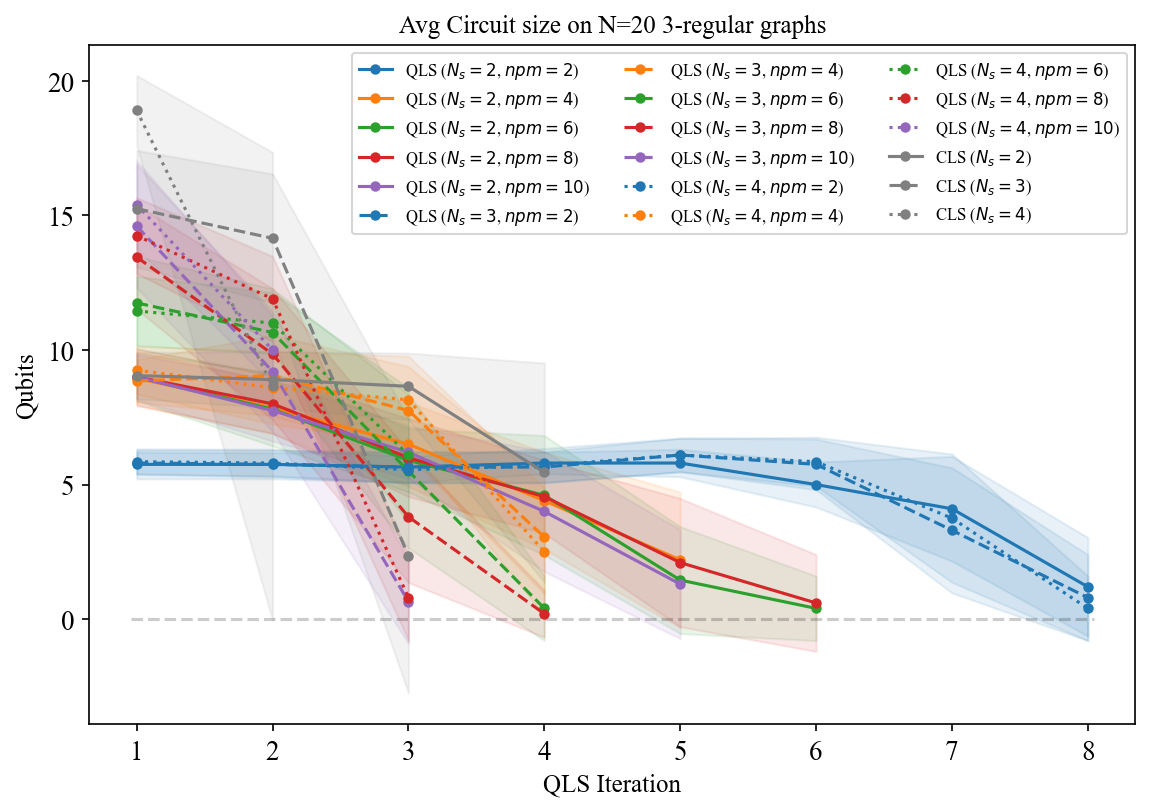

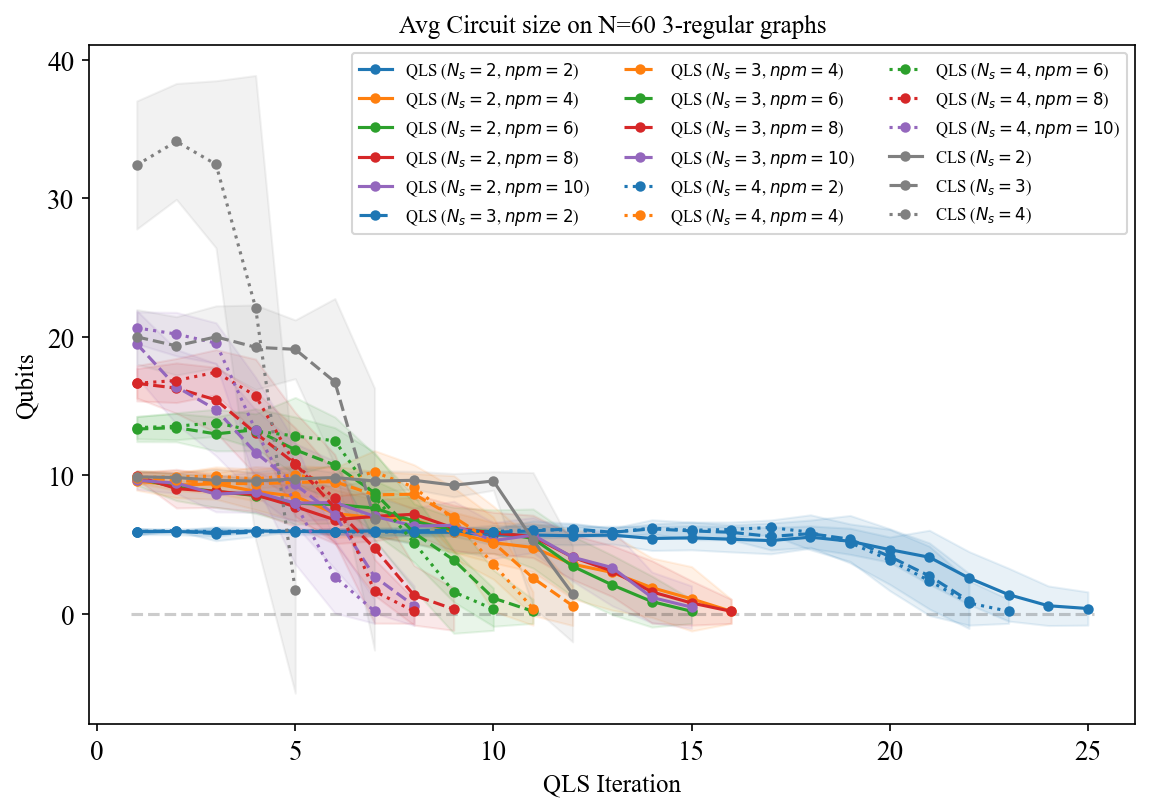

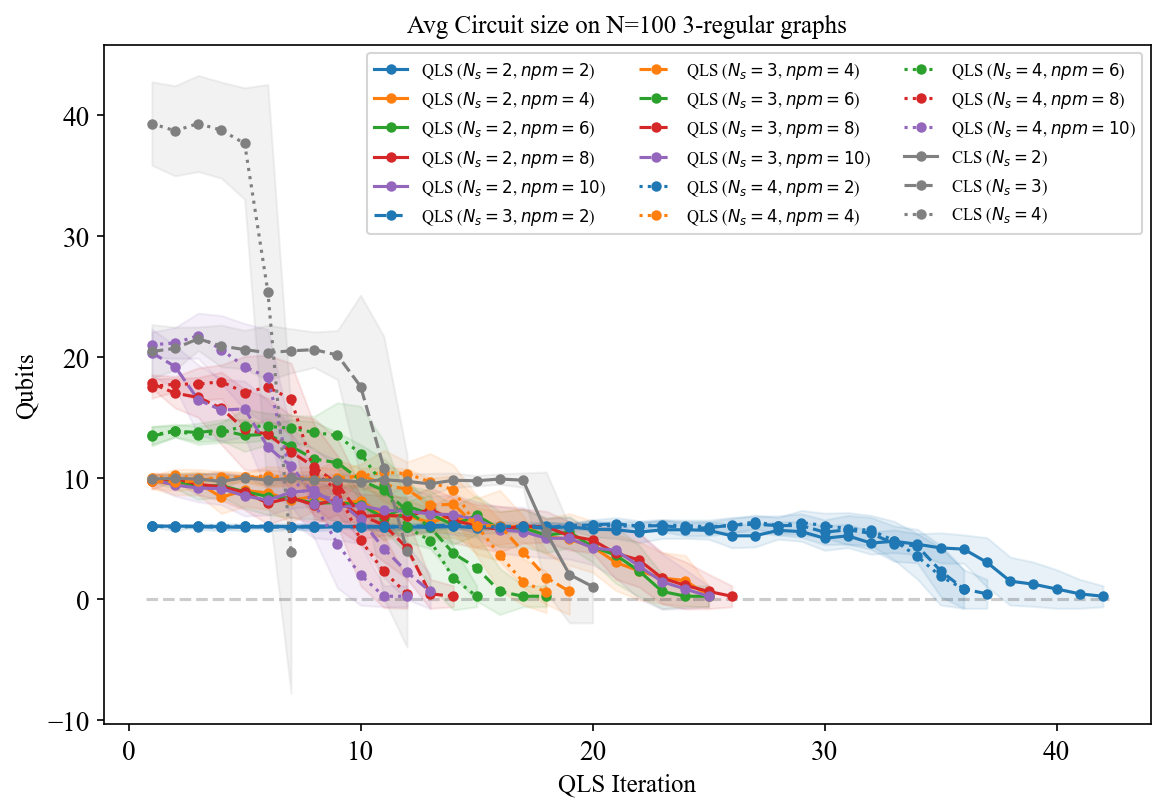

In [297]:
#extra_data = [('OnlineMIS (N=20)', onlinemis_N20), ('OnlineMIS (N=60)', onlinemis_N60), ('OnlineMIS (N=100)', onlinemis_N100)]
extra_data = None
savefn = 'figures/avg_qls_performance.pdf'
circuitsize(all_data, graph_type, graph_val, extra_data=extra_data, savefn=None, classical_data=all_classical_data, verbose=0)

# Plot num_iterations x approximation ratio x neighborhood size

In [ ]:
def iterations_performance_neighborhood(all_data, N, graph_type, graph_val, verbose=0, extra_data=None, savefn=None):
    ns_fmt_dict = {2:'-o', 3:'--o', 4:':o'}
    plt_tab_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
    npm_color_dict = {key: color for key, color in zip(list(set([d[1] for d in all_data])), plt_tab_colors)}
    print(npm_color_dict)
    fig, ax = plt.subplots(dpi=150, figsize=[9,6])
    
    # For each set of data with NPM = k
    for (ns, npm, data) in all_data:
        quantum = True
        if npm == -1:
            quantum = False
        if verbose:
            if quantum:
                print(f'NS{ns} NPM{npm}, {len(data)} graphs')
            else:
                print(f'NS{ns}, {len(data)} graphs')
        all_graph_y_vals = []
        # For each graph within that data set
        for (G, bh_mis, outs, graph_name) in data:
            if verbose:
                print(f'{graph_name}, {len(outs)}')
            all_rep_y_vals = []
            # For each repetition on each graph
            for (rep, out) in outs:
                qls_mis, history = out
                temp_y_vals = []
                # For each iteration within every repetition
                for iteration in history:
                    approximation_ratio = abs(hamming_weight(iteration[-1]) / bh_mis)
                    temp_y_vals.append(approximation_ratio)
                all_rep_y_vals.append((hamming_weight(qls_mis) / bh_mis, temp_y_vals))
            
            # Once all the reps have been collected, take the best repetition
            print(ns, npm, graph_name, len(outs))
            all_graph_y_vals.append(sorted(all_rep_y_vals, key=lambda tup: tup[0])[-1][1])
        
        # Once all the graphs have been collected, average over them
        max_iters = max([len(graph) for graph in all_graph_y_vals])
        #if npm == 4 and N == 60:
        #    max_iters -= 1
        #if npm == 3 and N == 100:
        #    max_iters -= 1
        avg_y_vals = []
        std_y_vals = []
        for i in range(max_iters):
            cur_iter_vals = []
            for graph in all_graph_y_vals:
                if i < len(graph):
                    cur_iter_vals.append(graph[i])
            avg_y_vals.append(np.mean(cur_iter_vals))
            std_y_vals.append(np.std(cur_iter_vals))
            
        # After all the data has been averaged, plot the results
        if quantum:
            label = f'QLS $N_s = {ns}$, $npm = {npm}$'
            fmt = ns_fmt_dict[ns]
            color = npm_color_dict[npm]
        else:
            label = f'CLS $N_s = {ns}$'
            fmt = ns_fmt_dict[ns]
            color = 'grey'
            
        xvals = np.arange(1, len(avg_y_vals)+1)
        ax.errorbar(xvals, avg_y_vals, label=label, fmt=fmt, c=color, ms=4)

        y1 = [m+s for m, s in zip(avg_y_vals, std_y_vals)]
        y2 = [m-s for m, s in zip(avg_y_vals, std_y_vals)]
        ax.fill_between(xvals, y1, y2, alpha=0.1, color=color)
    
    if extra_data is not None:
        for (label, val) in extra_data:
            ax.axhline(y=val, ls='--', alpha=0.4, label=label)
        
    ax.axhline(y=1, ls='--', c='k', alpha=0.2)
    ax.legend(fontsize=8, ncol=2)
    ax.set_ylabel('Boppana-Halldorsson Approximation Ratio', fontsize=13)
    ax.set_xlabel('Iteration', fontsize=13)
    ax.set_title(f'Average QLS performance ({N} node, {graph_type}{graph_val} graphs)')
    
    if savefn is not None:
        plt.savefig(savefn)
    
    plt.show()
    plt.close()

# Plot num_iterations x approximation ratio x num_partial_mixers

# Plot neighborhood size x approximation ratio x neighborhood size